# 加载环境和基础库

In [ ]:
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from grpc_env import GrpcEnv

In [ ]:
env = GrpcEnv("cartpole", "127.0.0.1", 9090)
try:
    print(env.env_id)   
    env = Monitor(env)
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        tensorboard_log="./ppo_cartpole_tensorboard/",
        learning_rate=0.001,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.0,
    )
    model.learn(total_timesteps=10000)
    
except Exception as e:
    print(f"Error during model initialization: {e}")
finally:
    env.close()

Connected to: Simulation gRPC Service v1.0.0
Available scenarios: ['simple', 'cartpole']
Environment created: grpc_env_cartpole_5230 (scenario: cartpole)
Scenario 'cartpole' loaded:
  Action space: Discrete(2)
  Observation space: Box([-4.8e+00 -1.0e+06 -4.2e-01 -1.0e+06], [4.8e+00 1.0e+06 4.2e-01 1.0e+06], (4,), float32)
grpc_env_cartpole_5230
Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_cartpole_tensorboard/PPO_4


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.4     |
|    ep_rew_mean     | 21.4     |
| time/              |          |
|    fps             | 908      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.3        |
|    ep_rew_mean          | 27.3        |
| time/                   |             |
|    fps                  | 768         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014576845 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.682      |
|    explained_variance   | -0.00205    |
|    learning_rate        | 0.

Environment closed: Environment grpc_env_cartpole_5230 closed successfully


# 测试模型效果 & 用数据统计图展示模型训练效果

In [26]:
"""改进的测试代码 - 显示 CartPole 关键指标"""
episode_rewards = []
episode_lengths = []
angle_histories = []  # 记录角度变化

try:
    env = GrpcEnv("cartpole", "127.0.0.1", 9090)
    for episode in range(5):
        obs, _ = env.reset()
        episode_reward = 0
        steps = 0
        angles = []  # 本轮角度记录

        print(f"\nEpisode {episode + 1}:")
        # 假设标准 CartPole 格式
        if len(obs) >= 4:
            print(f"  Initial: cart_pos={obs[0]:.3f}, cart_vel={obs[1]:.3f}, pole_angle={obs[2]:.3f}°, pole_vel={obs[3]:.3f}")
        
        while True:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            
            if len(obs) >= 3:
                pole_angle_deg = np.degrees(obs[2])  # 转换为度数
                angles.append(abs(pole_angle_deg))
                
                print(f"  Step {steps}: action={action}, pole_angle={pole_angle_deg:.1f}°, reward={reward:.3f}")

            if terminated or truncated:
                break

        episode_rewards.append(episode_reward)
        episode_lengths.append(steps)
        angle_histories.append(angles)

        print(f"  Episode reward: {episode_reward:.3f}, steps: {steps}")
        if angles:
            print(f"  Avg angle deviation: {np.mean(angles):.1f}°, Max: {np.max(angles):.1f}°")

    print(f"\nOverall Performance:")
    print(f"Average reward: {np.mean(episode_rewards):.3f} ± {np.std(episode_rewards):.3f}")
    print(f"Average length: {np.mean(episode_lengths):.1f} ± {np.std(episode_lengths):.1f}")
    
    # 训练好的指标
    if angle_histories:
        all_angles = np.concatenate(angle_histories)
        print(f"Angle stability: {np.mean(all_angles):.1f}° ± {np.std(all_angles):.1f}°")
        stable_ratio = np.mean(all_angles < 5.0) * 100  # 5度内认为稳定
        print(f"Stable time (< 5°): {stable_ratio:.1f}%")

finally:
    env.close()

Connected to: Simulation gRPC Service v1.0.0
Available scenarios: ['cartpole', 'simple']
Environment created: grpc_env_cartpole_1072 (scenario: cartpole)
Scenario 'cartpole' loaded:
  Action space: Discrete(2)
  Observation space: Box([-4.8e+00 -1.0e+06 -4.2e-01 -1.0e+06], [4.8e+00 1.0e+06 4.2e-01 1.0e+06], (4,), float32)

Episode 1:
  Initial: cart_pos=0.009, cart_vel=-0.003, pole_angle=-0.004°, pole_vel=0.013
  Step 1: action=1, pole_angle=-0.2°, reward=1.000
  Step 2: action=0, pole_angle=-0.5°, reward=1.000
  Step 3: action=0, pole_angle=-0.5°, reward=1.000
  Step 4: action=1, pole_angle=-0.2°, reward=1.000
  Step 5: action=0, pole_angle=-0.1°, reward=1.000
  Step 6: action=1, pole_angle=0.2°, reward=1.000
  Step 7: action=1, pole_angle=0.2°, reward=1.000
  Step 8: action=0, pole_angle=-0.1°, reward=1.000
  Step 9: action=1, pole_angle=-0.1°, reward=1.000
  Step 10: action=0, pole_angle=-0.5°, reward=1.000
  Step 11: action=0, pole_angle=-0.5°, reward=1.000
  Step 12: action=1, pol

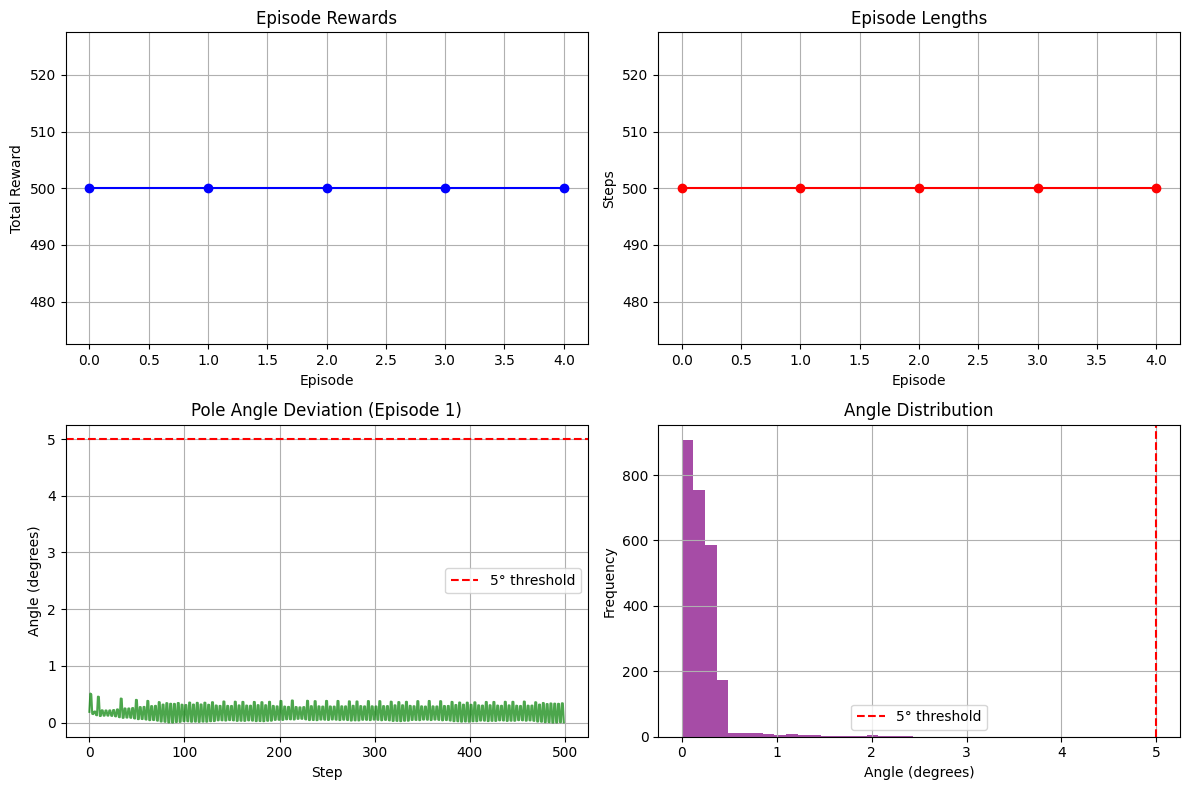

In [27]:
"""可视化 CartPole 平衡效果"""
import matplotlib.pyplot as plt

# 绘制角度变化图
plt.figure(figsize=(12, 8))

# 子图1：每轮奖励
plt.subplot(2, 2, 1)
plt.plot(episode_rewards, 'bo-')
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

# 子图2：每轮步数
plt.subplot(2, 2, 2)
plt.plot(episode_lengths, 'ro-')
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)

# 子图3：角度稳定性（选一轮显示）
if angle_histories:
    plt.subplot(2, 2, 3)
    plt.plot(angle_histories[0], 'g-', alpha=0.7)
    plt.axhline(y=5, color='r', linestyle='--', label='5° threshold')
    plt.title(f'Pole Angle Deviation (Episode 1)')
    plt.xlabel('Step')
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.grid(True)

# 子图4：所有轮次角度分布
if angle_histories:
    plt.subplot(2, 2, 4)
    all_angles = np.concatenate(angle_histories)
    plt.hist(all_angles, bins=20, alpha=0.7, color='purple')
    plt.axvline(x=5, color='r', linestyle='--', label='5° threshold')
    plt.title('Angle Distribution')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()